# XGBoost Model Approach (STA4365 Group 10)
# Author: Andres Machado
# Date: 04/29/2025

---

## Rough Outline:

- Definitions of XGBoost, GBoost, and Boosting.
- Clearly define what question we are answering with the data.
- Import the data, deal with NaNs, create/remove features, etc.
- Fit baseline models and record MAE.
- Feature engineer and fit more baseline models
- Hypertune the best performing models to create best MAEs possible.
- Conclusions

---

### Describing the XGBoost model:

Resources: 

https://xgboost.readthedocs.io/en/stable/index.html (XGBoost Documentation)

https://medium.com/@prathameshsonawane/xgboost-how-does-this-work-e1cae7c5b6cb (XGBoost)

https://www.ibm.com/think/topics/boosting (Boosting)

https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/ (Gradient Boosting)

XGBoost (short for Extreme Gradient Boosting) is an advanced implementation of the ever so popular gradient boosting algorithm. It is a powerful, flexible ML algorithm used a lot when data is presented in a tabular form. It has become infamous in ML competitions and tasks all over the world because of its great performance.

Boosting is an ensemble learning method that combines a set of weak learners into a strong learner to minimize training errors. As it is an ensemble learner that means boosting methods are made up of base learners (weak learners), or models, who all work collectively to achieve a better prediction. Base learners on their own can't achieve good performance but aggregating all the base learners can yield to greater model performance. It learns sequentially by fitting a model then gathering its errors, followed by another model and the process repeats. Essentially, you are building multiple models (typically of the same type) where each of which learns to fix the prediction errors of a prior model in the sequence of models. You can think of a boosting method as a model of models.

There are many types of boosting methods:
- Gradient Boosting 
- Ada Boosting
- Stochastic Gradient Boosting
- Extreme Gradient Boosting (XGBoost)

Gradient Boosting is the framework XGBoost is built on. Gradient boosting learners train themselves on residual errors of the previous predictors. It aims to optimize a loss function (that is differentiable) with gradient descent, that's where the "gradient" in gradient boosting comes into play. For our purposes, we are using it for a regressive task so an example loss function can be the squared errors/residuals. Since it is a boosting algorithm, its base learners of choice are decision trees. More specific to our case, regression trees that are used to output real values for splits and whose output can be added together, allowing subsequent models to be added and "correct" the residuals in the prediction.

The problem with using decision trees as the weak learners is that they tend to be constructed in a "greedy" manner. This means they choose their best split points based on purity scores or to minimize the loss. This can make them very flexible but at the same time over-fit to the training data. The decision trees may also grow to be very large in size adding much more computational cost to fitting multiple models. Luckily, many gradient boosting implementations have found solutions to fix the over fitting and "greedy" nature of the algorithm. This includes constraining the trees by having maximum number of layers, depth, nodes, splits, or leaf nodes. Another way to fix this is to penalize the weights by using L1, L2, or a combination of the two (called Elastic-Net) regularization techniques. Since gradient descent is part of the algorithm, you can also tweak it by changing the learning rate or use a stochastic gradient as opposed to a "full" gradient.

What results is a boosting algorithm that is powerful, flexible, yet can perform well with new data coming into it. So, why the need for XGBoost? Well, the main reason most point to is performance. XGBoost is much more efficient than traditional gradient boosting. It allows users to hyper tune many different parameters for learning, regularization, tree pruning, all in one package. With gradient boosting, these processes are still possible, but they need to be implemented separately, meaning the improvements to over fitting and generalization don't come standard. Where XGBoost shines is the way it computes its base learners. It leverages parallel processing techniques which is ideal for large-scale datasets. Additionally, feature importance scores are something XGBoost calculates which can help in generalization. Finally, one big benefit XGBoost has is its innate ability to model even if there is missing data. According to the documentation, "XGBoost supports missing values by default. In tree algorithms, branch directions for missing values are learned during training."  Objectively, both methods tout the same benefits as far as learning goes. Yet, its XGBoost that is gaining popularity due to its efficiency and ease of use for any size data set.


---

### What are we using XGBoost for?

Our main question we want answered in our dataset is the following: How accurately can we a given model predict the last ten minutes of a stock's movement utilizing time series data from the rest of the trading day? 

What we will do with XGBoost and try predict `target` using the non-identification features from the data set. We then will look at the features scores and see if we can spot a pattern in the features that XGBoost is trying to highlight. Afterwards, we will use PCA on the feature matrix. Again, looking for patterns to see what is explaining more of the variance in the data. Then, we will fit XGBoost on a different numbers of principal components to see if XGBoost gets better model performance or generalization with a smaller number of features. After that, we will feature engineer and baseline model the new design matrix with the new features.

Once all of that preliminary modeling is done, we will hyper-tune the best performing one and make predictions with it.

---

### Importing data and preliminary steps to modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

In [2]:
# Reading the data in
data = pd.read_csv('train.csv')
data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [3]:
nan_count = data.isna().sum()
nan_count

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

In [4]:
# Dropping far_price and near_price
data_v2 = data.drop(columns = ['far_price', 'near_price'])
# Dropping rows where target is NaN
data_v3 = data_v2.dropna(subset=['target'])

# Filling the nan values with 0
data_v3 = data_v3.fillna(0)
nan_count = data_v3.isna().sum()
nan_count

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
row_id                     0
dtype: int64

In [5]:
# Preparing the features and target variable
features = ['imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
            'bid_price', 'ask_price', 'bid_size', 'ask_size', 'wap', 'seconds_in_bucket']
target = 'target'

# Creating design matrix and response vector
X = data_v3[features]
y = data_v3[target]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 88)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Print the shapes for all the design matrices and response vectors
X_train_scaled.shape, y_train.shape, X_test_scaled.shape, y_test.shape

((4190313, 10), (4190313,), (1047579, 10), (1047579,))

---

### Baseline modeling:

We will start by importing the `XGBRegressor` from the `xgboost` package in python:

In [6]:
from xgboost import XGBRegressor

Then, we will fit the XGboost model to the training data and it evaluate it with the testing data using MAE. I will use the default parameters for everything just to get a baseline fit for our model:

In [7]:
# Fitting the XGBoost model
base_xgb_model = XGBRegressor(eval_metric = "mae",random_state = 88)
base_xgb_model.fit(X_train_scaled, y_train)

# Making predictions for MAE
y_pred = base_xgb_model.predict(X_test_scaled)

# MAE
mae = mean_absolute_error(y_true = y_test, y_pred = y_pred)
print(f'MAE: {mae:.4f}')

MAE: 6.2840


Now, let's observe the feature importance plot:

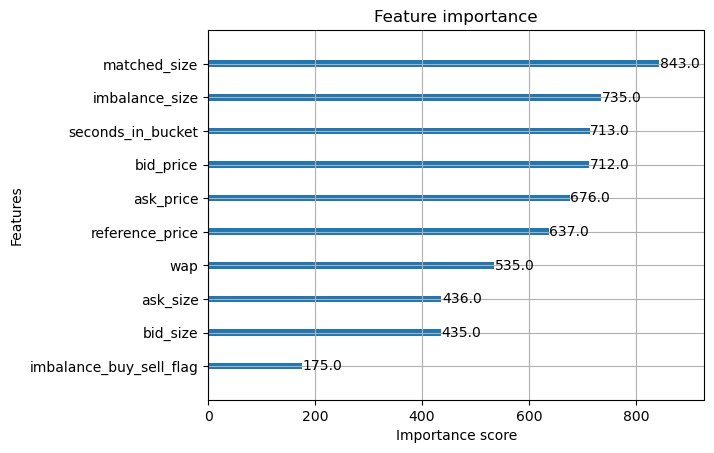

In [8]:
# Setting the features to be actual feature names rather than f1, f2, etc.
base_xgb_model.get_booster().feature_names = features

# Plotting
from xgboost import plot_importance
plot_importance(base_xgb_model)
plt.show()

Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. As we can see, the model is more reliant on the sizes of amount matched and unmatched at the reference price for predictive power. It also take into account the reference, bid, and ask prices as powerful assets. The bid/ask size and imbalance_buy_sell_flag are among the weaker features. As expected, seconds_in_bucket is a powerful feature as movement should be more intense as the final moments of the trading day come to a close.

Now, let's perform principal component analysis (PCA) on the features and see what explained variance ratio is for the first five components:

In [9]:
# PCA Function
from sklearn.decomposition import PCA

# Creating PCA object
pca_5= PCA(n_components = 5)
X_pca_5_train = pca_5.fit_transform(X_train_scaled)
print(f'Explain variance ratio by component (as a percentage): {pca_5.explained_variance_ratio_ * 100}\n')
print(f'Total explained variance ratio (as a percentage): {pca_5.explained_variance_ratio_.sum() * 100}')

Explain variance ratio by component (as a percentage): [39.96552318 15.50919345 13.78679284  9.98962225  8.87849869]

Total explained variance ratio (as a percentage): 88.12963041078902


We chose 5 component arbitrarily, but as we can see the first five principal components explain roughly 88.13% of the total variance of the data. The first three components alone account for roughly 69.27%.

We have 10 features originally, this gave us a MAE of 6.28. The question now is will having 5 or 3 features (in the form of principal components) affect the performance of XGBoost. The simpler we can make our model without sacrificing performance, the better. Let's fit a model with 5 principal components and then with 3 and compare the performance with the first baseline model:

In [10]:
# Let's get the 5 PC, PCA transform for X_test 
X_pca_5_test = pca_5.transform(X_test_scaled)

# First, fit the pca with three components only
pca_3 = PCA(n_components = 3)
X_pca_3_train = pca_3.fit_transform(X_train_scaled)
X_pca_3_test = pca_3.transform(X_test_scaled)

# Now, fitting two baseline XGBoost models with the two PCA transformed design matrices.
# Remembering to clone the baseline model to differentiate the three different models
from sklearn.base import clone

pca3_xgboost = clone(base_xgb_model).fit(X_pca_3_train, y_train)
pca5_xgboost = clone(base_xgb_model).fit(X_pca_5_train, y_train)

# Gathering MAE
y_pred_pca3 = pca3_xgboost.predict(X_pca_3_test)
y_pred_pca5 = pca5_xgboost.predict(X_pca_5_test)

mae_pca3 = mean_absolute_error(y_true = y_test, y_pred = y_pred_pca3)
mae_pca5 = mean_absolute_error(y_true = y_test, y_pred = y_pred_pca5)

print(f'MAE for 3 PC\'s PCA: {mae_pca3:.4f}')
print(f'MAE for 5 PC\'s PCA: {mae_pca5:.4f}')

MAE for 3 PC's PCA: 6.4069
MAE for 5 PC's PCA: 6.3662


Based on these results, one can conclude that using PCA doesn't drastically affect model's performance. The MAE did get slightly worse but the difference is almost negligible (~0.8 for 5 PC PCA and ~1.3 for 3 PC PCA). If one were scaling this model to a tremendously larger dataset, it might be in their best interest to fit it using PCA on the design matrix.

PCA doesn't have its own built in feature importance function but the math behind PCA can explain the magnitude of each features importance. You see each principal component in PCA is a weighted linear combination of the original features, where the loadings (weights) indicate how much each feature contributes. The magnitude of a loading reflects the strength of a feature’s influence on that component, regardless of direction. By sorting the absolute values of these loadings, you can identify which features have the greatest impact on the structure of each principal component, making it easier to interpret what each component represents. Here is some code that does this for the first three principal components:

In [11]:
np.set_printoptions(suppress=True) # Getting rid of scientific notation

loadings = pca_3.components_ # Gathering the loadings

for i in range(loadings.shape[0]):
    # Getting the i'th components loadings
    component_i = loadings[i]
    # Sorting in descending order the loadings and getting the indices
    top_indices = np.argsort(np.abs(component_i))[::-1]
    
    # Gathering the feature names and sorting in order of importance
    feature_names = X.columns
    top_features = feature_names[top_indices[:10]]
    # Gathering the weights/loadings in order
    top_weights = component_i[top_indices[:10]]

    # Printing analysis
    print(f'Principal Component {i + 1}\'s Loadings Analysis:')
    print('Top features:', top_features)
    print('Loadings in order of importance:', top_weights)
    print()

Principal Component 1's Loadings Analysis:
Top features: Index(['wap', 'reference_price', 'ask_price', 'bid_price',
       'imbalance_buy_sell_flag', 'matched_size', 'bid_size', 'ask_size',
       'seconds_in_bucket', 'imbalance_size'],
      dtype='object')
Loadings in order of importance: [ 0.49976055  0.49975557  0.49923992  0.49920687  0.04483406  0.00351098
  0.00270106 -0.00229484 -0.00085588  0.00022298]

Principal Component 2's Loadings Analysis:
Top features: Index(['matched_size', 'imbalance_size', 'bid_size', 'ask_size',
       'seconds_in_bucket', 'imbalance_buy_sell_flag', 'ask_price',
       'bid_price', 'reference_price', 'wap'],
      dtype='object')
Loadings in order of importance: [ 0.66389473  0.6132662   0.29329336  0.29235485  0.10748304 -0.00746758
 -0.00581226  0.00345106 -0.00105415 -0.0009133 ]

Principal Component 3's Loadings Analysis:
Top features: Index(['bid_size', 'ask_size', 'seconds_in_bucket', 'imbalance_size',
       'matched_size', 'imbalance_buy_sel

Below is the breakdown of what the analysis tells us:

-  The first principal component places a heavy emphasis on pricing aspects of a stock which is why the loadings for wap, reference_price, ask_price, and bid_price are the highest in that component.

- The second and the third principal components place more of their emphasis in sizing aspects of a particular stock with some added support from seconds_in_bucket.

- Each component essentially represents one characteristic of a particular stock at a particular time: 1st PC: Pricing, 2nd PC: Sizing, and 3rd PC: Sizing/Timing

---

### Feature Engineering

Resources:

https://www.kaggle.com/competitions/optiver-trading-at-the-close/discussion/486868

https://github.com/ChunhanLi/9th-kaggle-optiver-trading-close/blob/main/xgboost-training.ipynb

https://medium.com/@kis.andras.nandor/rolling-in-the-deep-unmasking-the-secrets-of-time-series-rolling-statistics-00387e5dfd49

For this section of the notebook, we wanted to perform some feature engineering to see if it can improve model performance. Since, most of us don't have much experience in the financial space, we decided that using some of the features commonly found in the contestants for this Kaggle competition would be best. If you are interested in learning more about the competition I would highly recommend checking out the following link: https://www.kaggle.com/competitions/optiver-trading-at-the-close/discussion/486868.

The 9th place winner of the competition posted a GitHub with some of the code he used for his submission. He goes by the GitHub username ChunhanLi and here the link to his notebook file: https://github.com/ChunhanLi/9th-kaggle-optiver-trading-close/blob/main/xgboost-training.ipynb. He also used an XGBoost model to fit his data and I won't use all of the features he created but I decided that I would borrow a couple. All the credit to the following features goes to him. He created his features from the same features that came with the original dataset for simplicity.

Here is a list of the features I implemented from his notebook and the formulation for them:
- $\text{ask\_money} = \text{ask\_size} \times \text{ask\_price}$
    - Essentially the amount of money in ask positions for a given stock at a given 10 second interval.

- $\text{bid\_money} = \text{bid\_size} \times \text{bid\_price}$
    - Essentially the amount of money in bid positions for a given stock at a given 10 second interval.

- $\text{volume\_money} = \text{ask\_size} \times \text{ask\_price} + \text{bid\_size} \times \text{bid\_price}$
    - Total amount of money in bid and ask positions for a given stock at a given 10 second interval.

- $\text{mid\_price} = \frac{\text{ask\_price} + \text{bid\_price}}{2}$
    - Price point right in the middle of ask and bid price positions for a given stock at a given 10 second interval.

- $\text{absolute\_spread} = \text{ask\_price} - \text{bid\_price}$
    - Difference between ask and bid price, used for liquidity measurement.

He also implemented some rolling means and standard deviations of the base features. When looking into why this may be predictable I stumbled upon the following Medium article (https://medium.com/@kis.andras.nandor/rolling-in-the-deep-unmasking-the-secrets-of-time-series-rolling-statistics-00387e5dfd49) that discusses Bollinger Bands. Then, I decided this would be a good way to create some meaningful features. The main reasons the article listed in support of rolling statistics is the following:
- Identify Trends: Smooth out short-term volatility to see the underlying trend.
- Detect Anomalies: Spot unusual spikes or drops that deviate from the trend.
- Understand Volatility: Measure how much the data fluctuates over time.

So, I decided was going to make rolling statistics on three variables: `imbalance_size`, `matched_size`, and `reference_price`. As for the particular reason why, there really is none. I chose these three as they were some of my more powerful features in the baseline model and figured they would be worth testing out. As far as the window I would do my rolling statistics in, I decided on using the same window sizes as ChunhanLi used of 3, 6, 18, and 36. The reason he used these is because they are factors of 540, the highest `seconds_in_bucket` ever gets.

Additionally, this is a time-series related task so it would be wise to add some lagging features. I will create it with the same three features and lag by 1, 2, and 3 second intervals. I chose these arbitrarily but I wanted to see the effect of these lag features.

 Let's implement these features into a new data frame, fit the baseline model and observe the model performance.

We'll start by creating the `ask_money`, `bid_money`, `volume_money`, `mid_price`, and `absolute_spread` features:

In [12]:
# Copying data frame for integrity purposes
data_v4 = data_v3.copy()

# ask_money feature
data_v4['ask_money'] = data_v4['ask_size'] * data_v4['ask_price']

# bid_money feature
data_v4['bid_money'] = data_v4['bid_size'] * data_v4['bid_price']

# volume_money feature
data_v4['volume_money'] = data_v4['ask_money'] + data_v4['bid_money']

# mid_price feature
data_v4['mid_price'] = (data_v4['ask_price'] + data_v4['bid_price']) / 2

# absolute_spread feature
data_v4['absolute_spread'] = data_v4['ask_price'] - data_v4['bid_price']

# Printing for verification
data_v4.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,ask_money,bid_money,volume_money,mid_price,absolute_spread
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0,8493.250819,60640.097518,69133.348337,0.999919,0.000214
1,1,0,0,166603.91,-1,0.999896,1642214.25,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1,20618.689359,3232.703764,23851.393123,1.000278,0.000764
2,2,0,0,302879.87,-1,0.999561,1819368.03,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2,19000.660510,37933.340268,56934.000778,0.999850,0.000895
3,3,0,0,11917682.27,-1,1.000171,18389745.62,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3,479134.912934,2324.897675,481459.810609,1.000107,0.000215
4,4,0,0,447549.96,-1,0.999532,17860614.95,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4,434.106946,16475.549763,16909.656708,0.999705,0.000622


Now, we will create rolling statistics for `imbalance_size`,`matched_size`, and `reference_price`:

In [13]:
# Apply rolling mean and std per group using groupby
# Using for loop to iterate through each column

rolling_stat_cols = ['imbalance_size', 'matched_size', 'reference_price']

for col in rolling_stat_cols:
    for window in [3, 6, 18, 36]:
        rolled_stats = (
            data_v4.groupby(['stock_id', 'date_id'])[col]
            .rolling(window=window, min_periods=1)
        )
        data_v4[f'rolling{window}_mean_{col}'] = rolled_stats.mean().reset_index(drop=True)
        data_v4[f'rolling{window}_std_{col}'] = rolled_stats.std().reset_index(drop=True)
        
data_v4.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,ask_money,bid_money,volume_money,mid_price,absolute_spread,rolling3_mean_imbalance_size,rolling3_std_imbalance_size,rolling6_mean_imbalance_size,rolling6_std_imbalance_size,rolling18_mean_imbalance_size,rolling18_std_imbalance_size,rolling36_mean_imbalance_size,rolling36_std_imbalance_size,rolling3_mean_matched_size,rolling3_std_matched_size,rolling6_mean_matched_size,rolling6_std_matched_size,rolling18_mean_matched_size,rolling18_std_matched_size,rolling36_mean_matched_size,rolling36_std_matched_size,rolling3_mean_reference_price,rolling3_std_reference_price,rolling6_mean_reference_price,rolling6_std_reference_price,rolling18_mean_reference_price,rolling18_std_reference_price,rolling36_mean_reference_price,rolling36_std_reference_price
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0,8493.250819,60640.097518,69133.348337,0.999919,0.000214,3.180603e+06,NaN,3.180603e+06,NaN,3.180603e+06,NaN,3.180603e+06,NaN,1.338028e+07,NaN,1.338028e+07,NaN,1.338028e+07,NaN,1.338028e+07,NaN,0.999812,NaN,0.999812,NaN,0.999812,NaN,0.999812,NaN
1,1,0,0,166603.91,-1,0.999896,1642214.25,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1,20618.689359,3232.703764,23851.393123,1.000278,0.000764,2.240188e+06,1.329948e+06,2.240188e+06,1.329948e+06,2.240188e+06,1.329948e+06,2.240188e+06,1.329948e+06,1.432069e+07,1.329948e+06,1.432069e+07,1.329948e+06,1.432069e+07,1.329948e+06,1.432069e+07,1.329948e+06,0.999919,0.000151,0.999919,0.000151,0.999919,0.000151,0.999919,0.000151
2,2,0,0,302879.87,-1,0.999561,1819368.03,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2,19000.660510,37933.340268,56934.000778,0.999850,0.000895,1.926716e+06,1.085898e+06,1.926716e+06,1.085898e+06,1.926716e+06,1.085898e+06,1.926716e+06,1.085898e+06,1.463416e+07,1.085898e+06,1.463416e+07,1.085898e+06,1.463416e+07,1.085898e+06,1.463416e+07,1.085898e+06,0.999919,0.000107,0.999919,0.000107,0.999919,0.000107,0.999919,0.000107
3,3,0,0,11917682.27,-1,1.000171,18389745.62,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3,479134.912934,2324.897675,481459.810609,1.000107,0.000215,1.299773e+06,0.000000e+00,1.769980e+06,9.404150e+05,1.769980e+06,9.404150e+05,1.769980e+06,9.404150e+05,1.526111e+07,0.000000e+00,1.479090e+07,9.404150e+05,1.479090e+07,9.404150e+05,1.479090e+07,9.404150e+05,1.000026,0.000107,0.999972,0.000138,0.999972,0.000138,0.999972,0.000138
4,4,0,0,447549.96,-1,0.999532,17860614.95,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4,434.106946,16475.549763,16909.656708,0.999705,0.000622,1.272583e+06,4.709346e+04,1.659625e+06,8.509856e+05,1.659625e+06,8.509856e+05,1.659625e+06,8.509856e+05,1.528830e+07,4.709346e+04,1.490125e+07,8.509856e+05,1.490125e+07,8.509856e+05,1.490125e+07,8.509856e+05,1.000169,0.000270,1.000069,0.000247,1.000069,0.000247,1.000069,0.000247


Now, we create the lagging observations in a similar manner:

In [14]:
for col in rolling_stat_cols:
    for lag in [1, 2, 3]:
        data_v4[f'lag{lag}_{col}'] = (
            data_v4.groupby(['stock_id', 'date_id'])[col].shift(lag)
        )

data_v4.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,ask_money,bid_money,volume_money,mid_price,absolute_spread,rolling3_mean_imbalance_size,rolling3_std_imbalance_size,rolling6_mean_imbalance_size,rolling6_std_imbalance_size,rolling18_mean_imbalance_size,rolling18_std_imbalance_size,rolling36_mean_imbalance_size,rolling36_std_imbalance_size,rolling3_mean_matched_size,rolling3_std_matched_size,rolling6_mean_matched_size,rolling6_std_matched_size,rolling18_mean_matched_size,rolling18_std_matched_size,rolling36_mean_matched_size,rolling36_std_matched_size,rolling3_mean_reference_price,rolling3_std_reference_price,rolling6_mean_reference_price,rolling6_std_reference_price,rolling18_mean_reference_price,rolling18_std_reference_price,rolling36_mean_reference_price,rolling36_std_reference_price,lag1_imbalance_size,lag2_imbalance_size,lag3_imbalance_size,lag1_matched_size,lag2_matched_size,lag3_matched_size,lag1_reference_price,lag2_reference_price,lag3_reference_price
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0,8493.250819,60640.097518,69133.348337,0.999919,0.000214,3.180603e+06,NaN,3.180603e+06,NaN,3.180603e+06,NaN,3.180603e+06,NaN,1.338028e+07,NaN,1.338028e+07,NaN,1.338028e+07,NaN,1.338028e+07,NaN,0.999812,NaN,0.999812,NaN,0.999812,NaN,0.999812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,0,166603.91,-1,0.999896,1642214.25,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1,20618.689359,3232.703764,23851.393123,1.000278,0.000764,2.240188e+06,1.329948e+06,2.240188e+06,1.329948e+06,2.240188e+06,1.329948e+06,2.240188e+06,1.329948e+06,1.432069e+07,1.329948e+06,1.432069e+07,1.329948e+06,1.432069e+07,1.329948e+06,1.432069e+07,1.329948e+06,0.999919,0.000151,0.999919,0.000151,0.999919,0.000151,0.999919,0.000151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,0,302879.87,-1,0.999561,1819368.03,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2,19000.660510,37933.340268,56934.000778,0.999850,0.000895,1.926716e+06,1.085898e+06,1.926716e+06,1.085898e+06,1.926716e+06,1.085898e+06,1.926716e+06,1.085898e+06,1.463416e+07,1.085898e+06,1.463416e+07,1.085898e+06,1.463416e+07,1.085898e+06,1.463416e+07,1.085898e+06,0.999919,0.000107,0.999919,0.000107,0.999919,0.000107,0.999919,0.000107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,0,11917682.27,-1,1.000171,18389745.62,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3,479134.912934,2324.897675,481459.810609,1.000107,0.000215,1.299773e+06,0.000000e+00,1.769980e+06,9.404150e+05,1.769980e+06,9.404150e+05,1.769980e+06,9.404150e+05,1.526111e+07,0.000000e+00,1.479090e+07,9.404150e+05,1.479090e+07,9.404150e+05,1.479090e+07,9.404150e+05,1.000026,0.000107,0.999972,0.000138,0.999972,0.000138,0.999972,0.000138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,0,447549.96,-1,0.999532,17860614.95,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4,434.106946,16475.549763,16909.656708,0.999705,0.000622,1.272583e+06,4.709346e+04,1.659625e+06,8.509856e+05,1.659625e+06,8.509856e+05,1.659625e+06,8.509856e+05,1.528830e+07,4.709346e+04,1.490125e+07,8.509856e+05,1.490125e+07,8.509856e+05,1.490125e+07,8.509856e+05,1.000169,0.000270,1.000069,0.000247,1.000069,0.000247,1.000069,0.000247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Observing nan counts 
nan_count_2 = data_v4.isna().sum()
nan_count_2

stock_id                               0
date_id                                0
seconds_in_bucket                      0
imbalance_size                         0
imbalance_buy_sell_flag                0
reference_price                        0
matched_size                           0
bid_price                              0
bid_size                               0
ask_price                              0
ask_size                               0
wap                                    0
target                                 0
time_id                                0
row_id                                 0
ask_money                              0
bid_money                              0
volume_money                           0
mid_price                              0
absolute_spread                        0
rolling3_mean_imbalance_size          88
rolling3_std_imbalance_size        95323
rolling6_mean_imbalance_size          88
rolling6_std_imbalance_size        95323
rolling18_mean_i

In [16]:
# Dropping all NA rows
data_v5 = data_v4.dropna()
data_v5

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,ask_money,bid_money,volume_money,mid_price,absolute_spread,rolling3_mean_imbalance_size,rolling3_std_imbalance_size,rolling6_mean_imbalance_size,rolling6_std_imbalance_size,rolling18_mean_imbalance_size,rolling18_std_imbalance_size,rolling36_mean_imbalance_size,rolling36_std_imbalance_size,rolling3_mean_matched_size,rolling3_std_matched_size,rolling6_mean_matched_size,rolling6_std_matched_size,rolling18_mean_matched_size,rolling18_std_matched_size,rolling36_mean_matched_size,rolling36_std_matched_size,rolling3_mean_reference_price,rolling3_std_reference_price,rolling6_mean_reference_price,rolling6_std_reference_price,rolling18_mean_reference_price,rolling18_std_reference_price,rolling36_mean_reference_price,rolling36_std_reference_price,lag1_imbalance_size,lag2_imbalance_size,lag3_imbalance_size,lag1_matched_size,lag2_matched_size,lag3_matched_size,lag1_reference_price,lag2_reference_price,lag3_reference_price
573,0,0,30,1299772.70,1,1.000133,15261106.63,1.000026,55998.00,1.000133,46203.30,1.000085,5.450249,3,0_30_0,46209.445039,55999.455948,102208.900987,1.000080,0.000107,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,63042.708333,183517.678206,1.911386e+05,2.765685e+05,8.835970e+06,4028.432636,8.834807e+06,2848.532034,8.602368e+06,253484.956653,8.443731e+06,3.556735e+05,1.000571,0.000102,1.000418,0.000221,1.000311,0.000189,1.000333,0.000187,1299772.70,1299772.70,3180602.69,15261106.63,15261106.63,13380276.64,0.999919,1.000026,0.999812
574,1,0,30,165923.20,-1,0.999896,1642894.96,0.999896,4254.00,1.000308,3574.83,1.000120,-5.149841,3,0_30_1,3575.931048,4253.557584,7829.488632,1.000102,0.000412,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,32113.727222,136247.005728,1.834931e+05,2.734308e+05,8.888678e+06,89346.111505,8.861161e+06,64044.462296,8.658215e+06,218087.481009,8.465652e+06,3.650293e+05,1.000639,0.000059,1.000520,0.000154,1.000333,0.000207,1.000347,0.000195,165923.20,165923.20,166603.91,1642894.96,1642894.96,1642214.25,0.999955,0.999955,0.999896
575,2,0,30,169764.64,-1,0.999351,1952483.25,0.999193,18974.00,0.999877,189.87,0.999870,-5.819797,3,0_30_2,189.846646,18958.687982,19148.534628,0.999535,0.000684,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1.764357e+05,2.703125e+05,8.961401e+06,108820.810551,8.897523e+06,98149.233625,8.717397e+06,162564.024626,8.488197e+06,3.756745e+05,1.000639,0.000059,1.000571,0.000091,1.000362,0.000202,1.000356,0.000196,169764.64,184766.21,302879.87,1952483.25,1937481.68,1819368.03,0.999351,0.999561,0.999561
576,3,0,30,10874033.58,-1,0.999827,19433394.31,0.999784,155734.80,1.000042,11625.00,1.000024,1.130104,3,0_30_3,11625.488250,155701.161283,167326.649533,0.999913,0.000258,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1.699010e+05,2.672292e+05,9.031797e+06,34667.204760,8.933884e+06,109506.607960,8.744466e+06,175658.152182,8.509071e+06,3.840163e+05,1.000639,0.000059,1.000605,0.000083,1.000390,0.000208,1.000367,0.000202,10874033.58,10874033.58,11917682.27,19433394.31,19433394.31,18389745.62,0.999999,0.999870,1.000171
577,4,0,30,413690.70,-1,0.999878,17894474.21,0.999878,14468.00,1.000085,1012.97,1.000071,-2.589822,3,0_30_4,1013.056102,14466.234904,15479.291006,0.999981,0.000207,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1.638331e+05,2.641922e+05,9.051813e+06,0.000000,8.970245e+06,105721.182969,8.771535e+06,183665.036273,8.528455e+06,3.905470e+05,1.000639,0.000059,1.000639,0.000053,1.000424,0.000201,1.000378,0.000206,417742.24,417742.24,447549.96,17890422.68,17890422.68,17860614.95,0.999878,1.000154,0.999532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237887,107,480,540,1968147.17,1,0.998819,1

Here's a summary of what changes we made:

1. Addition of general stock KPI's features
- These include `ask_money`, `bid_money`, `volume_money`, `mid_price`, and `absolute_spread`.
- This will add additional features that may generalize the current features we have.

2. Addition of rolling statistics features
- Made up of the following three columns: `imbalance_size`,`matched_size`, and `reference_price`.
- Will help smooth out the radical, sharp changes in these columns and aid in detecting anomalies.

3. Addition of lag features
- Made up of the following three columns: `imbalance_size`,`matched_size`, and `reference_price`.
- Helps incorporate a sense of time-series analysis into our feature set. This may prove to be useful

4. Dropped all NA Rows
- With such a large dataset and many new features, dropping the NA rows are convenient. This may introduce bias into our dataset and may disrupt some of the time-series elements of this data.

In total we have 48 features which is 38 more than previously.

Now that we have all the features we wanted to create, let's fit a baseline XGBoost model to see how it performs:

In [17]:
# Creating new design matrix
X_v2 = data_v5.drop(columns=['stock_id', 'date_id', 'target', 'time_id', 'row_id'])
y_v2 = data_v5['target']

# Splitting the data into training and testing sets
X_v2_train, X_v2_test, y_v2_train, y_v2_test = train_test_split(X_v2, y_v2, test_size = 0.2, random_state = 88)

# Scaling the features
scaler_2 = StandardScaler()
X_v2_train_scaled = scaler_2.fit_transform(X_v2_train)
X_v2_test_scaled = scaler_2.transform(X_v2_test)

# Print the shapes for all the design matrices and response vectors
X_v2_train_scaled.shape, y_v2_train.shape, X_v2_test_scaled.shape, y_v2_test.shape

((3889509, 48), (3889509,), (972378, 48), (972378,))

In [18]:
# Fitting the new XGBoost base model
base2_xgb_model = XGBRegressor(eval_metric = "mae", random_state = 88)
base2_xgb_model.fit(X_v2_train_scaled, y_v2_train)

# Making predictions for MAE
y_v2_pred = base2_xgb_model.predict(X_v2_test_scaled)

# MAE
mae = mean_absolute_error(y_true = y_v2_test, y_pred = y_v2_pred)
print(f'MAE: {mae:.4f}')

MAE: 6.2431


Our MAE lowered by roughly 0.04 before hyper tuning. Let's observe the feature importance plot (it won't be as leligible due to the number of features but we want to observe general trends):

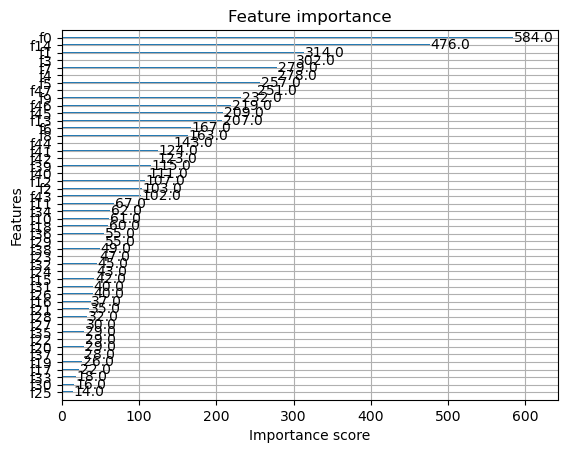

In [19]:
# Plotting
plot_importance(base2_xgb_model)
plt.show()

As we can see, majority of the features we created didn't add much value to our model. Let's see if PCA can get a very similar result:

In [20]:
# First, fit the pca with three components only
pca_3 = PCA(n_components = 3)
X_pca_3_train = pca_3.fit_transform(X_v2_train_scaled)
X_pca_3_test = pca_3.transform(X_v2_test_scaled)

# Now, fitting the baseline XGBoost models with the PCA transformed design matrix.
# Remembering to clone the baseline model to differentiate the two different models
from sklearn.base import clone

pca3_xgboost_2 = clone(base2_xgb_model).fit(X_pca_3_train, y_v2_train)

# Gathering MAE
y_pred_pca3 = pca3_xgboost_2.predict(X_pca_3_test)
mae_pca3 = mean_absolute_error(y_true = y_v2_test, y_pred = y_pred_pca3)
print(f'MAE for 3 PC\'s PCA: {mae_pca3:.4f}')

MAE for 3 PC's PCA: 6.3727


Again very similar to our previous results of PCA where it was able to generalize pretty well with just three principal components.

#### Final Thoughts on Baseline Models

In total we fit 5 baseline models. Here is the performance for all 5 in a neat list:
- Model 1: 10 features no PCA -> **MAE: 6.2840**
- Model 2: 10 features 3 PCs PCA -> **MAE: 6.4069**
- Model 3: 10 features 5 PCs PCA -> **MAE: 6.3662**
- Model 4: 48 features no PCA -> **MAE: 6.2431**
- Model 5: 48 features 3 PCs PCA -> **MAE: 6.3727**

After careful thought, we decided to move forward with the first model and fifth model we fit. They gave the best performance for the what they provided. We will now move onto hypertuning each of the models.

---

### Hypertuning the XGBoost models:

#### Model 1

To hypertune our XGBoost model, we have a multitude of parameters to choose from. Here's a list of what we will hypertune in our model (the descriptions are paraphrased from the documentation):

- `n_estimators`: Controls the number of trees built while modeling. Too low and it will underfit, too high and it will overfit. Default value is 100

- `max_depth`: Maximum depth of regressor trees. Increasing this will make the model more complex and more likely to overfit. Default value is 6.

- `eta`: The learning rate (step size) shrinkage used in update to prevent overfitting. It shrinks the feature weights to make the boosting process more conservative. Default value is 0.3.

- `min_child_weight`: Minimum sum of instance weight (hessian) needing in a child node. The larger it is, the more conservative the algorithm will be. Default value is 1.

- `subsample`: Subsample ratio of training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. Helps with overfitting. Default value is 1.

- `lambda`: L2 regularization term. Default value is 1.

- `alpha`: L1 regularization term. Default value is 0.

There are many more but we want to make sure the hypertuning finishes in a reasonable amount of time as well.

Not only can we train these 7, but we can also do some feature removal as well. The feature 'imbalance_buy_sell_flag' is not very effective and can be easily explained by other variables as shown in the correlation heat map. Let's get rid of it from our train and test matrices:

In [46]:
# Remaking the features list
features_fin = ['imbalance_size', 'reference_price', 'matched_size', 'bid_price', 
            'ask_price', 'bid_size', 'ask_size', 'wap', 'seconds_in_bucket']

# Filtering out imbalance_buy_sell_flag
X_train_2 = X_train[features_fin]
X_test_2 = X_test[features_fin]

# Rescaling the data
scaler = StandardScaler()
X_train_scaled_2 = scaler.fit_transform(X_train_2)
X_test_scaled_2 = scaler.transform(X_test_2)

The most impactful of these parameters are the first three as they are the baseline to the gradient boosting aspect of XGBoost. We will tune those first and the other 4 afterwards. To hypertune these parameters I will use `GridSearchCV` with 3 folds (for computation speed purposes). 

# **WARNING: IF YOU RUN THIS IT WILL TAKE 5+ MINUTES TO COMPLETE**

In [47]:
# Defining parameter grid
param_grid_1 = {
    'n_estimators': [10, 100, 500],
    'max_depth': [3, 5, 6, 7],
    'eta': [0.01, 0.1, 0.3, 0.5]
}

# Defining and fitting grid search
grid_search_1 = GridSearchCV(estimator = base_xgb_model, param_grid = param_grid_1,
                           cv = 3, n_jobs = -1)
grid_search_1.fit(X_train_scaled_2, y_train)

# Printing best parameters
print(grid_search_1.best_params_)

{'eta': 0.3, 'max_depth': 7, 'n_estimators': 500}


After an excruciating 6 minutes, we arrived at our first checkpoint. The `eta` parameter is sitting comfortably at 0.3. While the other two parameters are on the higher end of values I provided them. Let's try one more round of `GridSearchCV` but only tweak the `n_estimators` and `max_depth`:

# **WARNING: IF YOU RUN THIS IT WILL TAKE 2+ MINUTES TO COMPLETE**

In [48]:
# Testing out two other values for n_estimators and max_depth
param_grid_2 = {
    'n_estimators': [300, 500],
    'max_depth': [7, 8],
    'eta': [0.3]
}

# Defining and fitting grid search
grid_search_2 = GridSearchCV(estimator = base_xgb_model, param_grid = param_grid_2,
                           cv = 3, n_jobs = -1)
grid_search_2.fit(X_train_scaled_2, y_train)

# Printing best parameters
print(grid_search_2.best_params_)

{'eta': 0.3, 'max_depth': 8, 'n_estimators': 500}


As expected, the `max_depth` and `n_estimators` clinged to the upper end of their range. This is due to the fact that as you make it more complex, it fits better and that's due to the regressive trees that XGBoost uses for its base learners. To not induce overfitting, I am going to cap the `n_estimators` at 500 and `max_depth` at 7.

Now, let's tune the less important hyper parameters. I will only provide it at most three values for each hyper parameter:

# **WARNING: IF YOU RUN THIS IT WILL TAKE 20+ MINUTES TO COMPLETE**

In [49]:
# Keeping first three the same and testing out the other 4
param_grid_3 = {
    'n_estimators': [500],
    'max_depth': [7],
    'eta': [0.3],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 1],
    'lambda': [0, 0.5, 1],
    'alpha': [0, 0.5, 1]
}

# Defining and fitting grid search
grid_search_3 = GridSearchCV(estimator = base_xgb_model, param_grid = param_grid_3,
                           cv = 3, n_jobs = -1)
grid_search_3.fit(X_train_scaled_2, y_train)

# Printing best parameters
print(grid_search_3.best_params_)

{'alpha': 1, 'eta': 0.3, 'lambda': 1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 1}


As we can see, the optimal XGBoost parameters are above. One thing to note is the `alpha` and `lambda` parameters being set to 1. This will mean that we are using elastic net optimization on the weights. Also, the `subsample` equaling 1 is to be expected if performance on training data is key. This parameter grid that we just ran will be our optimal parameters for our best XGBoost model. Let's create it and calculate the MAE:

In [58]:
# Creating optimal parameters dictionary
optimal_params = {
    'n_estimators': 500,
    'max_depth': 7,
    'eta': 0.3,
    'min_child_weight': 1,
    'subsample': 1,
    'lambda': 1,
    'alpha': 1,
    'n_jobs': -1 # uses machines max performance (a.k.a all CPUs)
}

# Creating and fitting optimal XGBoost model
optimal_xgboost = XGBRegressor(**optimal_params)
optimal_xgboost.fit(X_train_scaled_2, y_train)

# Making predictions for MAE
y_pred = optimal_xgboost.predict(X_test_scaled_2)

# MAE
mae = mean_absolute_error(y_true = y_test, y_pred = y_pred)
print(f'MAE: {mae:.4f}')

MAE: 6.2582


As we can see, even with all the hyper parameter tuning we did (which totaled to about 30 minutes of computing time), the MAE only improved marginally. More specifically if we take the difference MAEs we see that the optimal XGBoost model achieved a lower score by 0.0258.

#### Model 5

The hyper tuning procedure is roughly the same so below is the implementation. I did however decide to add 1000 as a possible `n_estimators` in the parameter grid. Let's see how that changes what it chooses:

# **WARNING: IF YOU RUN THIS IT WILL TAKE 10+ MINUTES TO COMPLETE**

In [21]:
# Defining parameter grid
param_grid_4 = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 6, 7],
    'eta': [0.01, 0.1, 0.3, 0.5]
}

# Defining and fitting grid search
grid_search_4 = GridSearchCV(estimator = pca3_xgboost_2, param_grid = param_grid_4,
                           cv = 3, n_jobs = -1)
grid_search_4.fit(X_pca_3_train, y_v2_train)

# Printing best parameters
print(grid_search_4.best_params_)

{'eta': 0.1, 'max_depth': 3, 'n_estimators': 100}


This is something we definitely did not expect. Model 1 used as many estimators, as much depth, as it needed. Model 5 seems to be needing a complete opposite approach. All parameters are much lower and easier computation wise for Model 5 than model 1. Let's continue fine tuning:

# **WARNING: IF YOU RUN THIS IT WILL TAKE 2+ MINUTES TO COMPLETE**

In [23]:
# Keeping first three the same and testing out the other 4
param_grid_5 = {
    'n_estimators': [100],
    'max_depth': [3],
    'eta': [0.1],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 1],
    'lambda': [0, 0.5, 1],
    'alpha': [0, 0.5, 1]
}

# Defining and fitting grid search
grid_search_5 = GridSearchCV(estimator = pca3_xgboost_2, param_grid = param_grid_5,
                           cv = 3, n_jobs = -1)
grid_search_5.fit(X_pca_3_train, y_v2_train)

# Printing best parameters
print(grid_search_5.best_params_)

{'alpha': 0, 'eta': 0.1, 'lambda': 0, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1}


This parameter grid that we just ran will be our optimal parameters for our best XGBoost model for Model 5. Let's create it and calculate the MAE:

In [25]:
# Creating optimal parameters dictionary
optimal_params_2 = {
    'n_estimators': 100,
    'max_depth': 3,
    'eta': 0.1,
    'min_child_weight': 5,
    'subsample': 1,
    'lambda': 0,
    'alpha': 0,
    'n_jobs': -1 # uses machines max performance (a.k.a all CPUs)
}

# Creating and fitting optimal XGBoost model
optimal_xgboost_2 = XGBRegressor(**optimal_params_2)
optimal_xgboost_2.fit(X_pca_3_train, y_v2_train)

# Making predictions for MAE
y_pred = optimal_xgboost_2.predict(X_pca_3_test)

# MAE
mae = mean_absolute_error(y_true = y_v2_test, y_pred = y_pred)
print(f'MAE: {mae:.4f}')

MAE: 6.3675
